# "Binary Prediction of Smoker Status using Bio-Signals" Competition

Submission by: Atul Parida

## Overview
This notebook contains the code and analysis for the "Binary Prediction of Smoker Status using Bio-Signals" competition on Kaggle. In this competition, the goal is to build a machine learning model that predicts whether given biodata belongs to a smoker or not. We will explore the dataset, preprocess the text data, build and evaluate models, and make predictions.

## Table of Contents
1. [Data Exploration](#data-exploration)
2. [Data Preprocessing](#data-preprocessing)
3. [Model Building](#model-building)
4. [Model Evaluation](#model-evaluation)
5. [Results and Conclusion](#results-and-conclusion)


### Data Exploration

In [23]:
### Essential imports ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import sys

In [24]:
train_data_path = os.path.join(os.getcwd(), 'data', 'train.csv')
test_data_path = os.path.join(os.getcwd(), 'data', 'test.csv')
sample_submission_path = os.path.join(os.getcwd(), 'data', 'sample_submission.csv')
output_path = os.path.join(os.getcwd(), 'output', 'output.csv')

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [25]:
train_data.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [26]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [27]:
train_data.duplicated().sum()

0

In [28]:
features = list(train_data.copy(deep=True).columns)
features.remove('smoking')
print(f'Features: {features}')

Features: ['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']


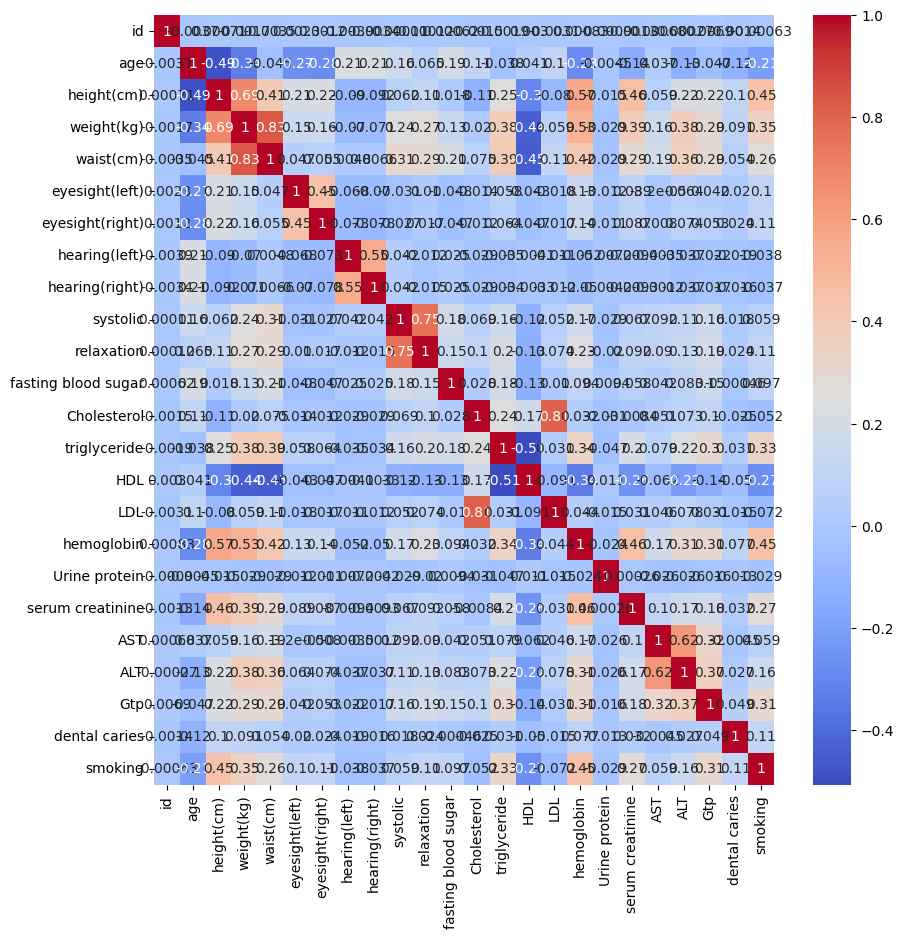

In [29]:
# Correlation matrix
corr = train_data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

<Axes: xlabel='AST', ylabel='ALT'>

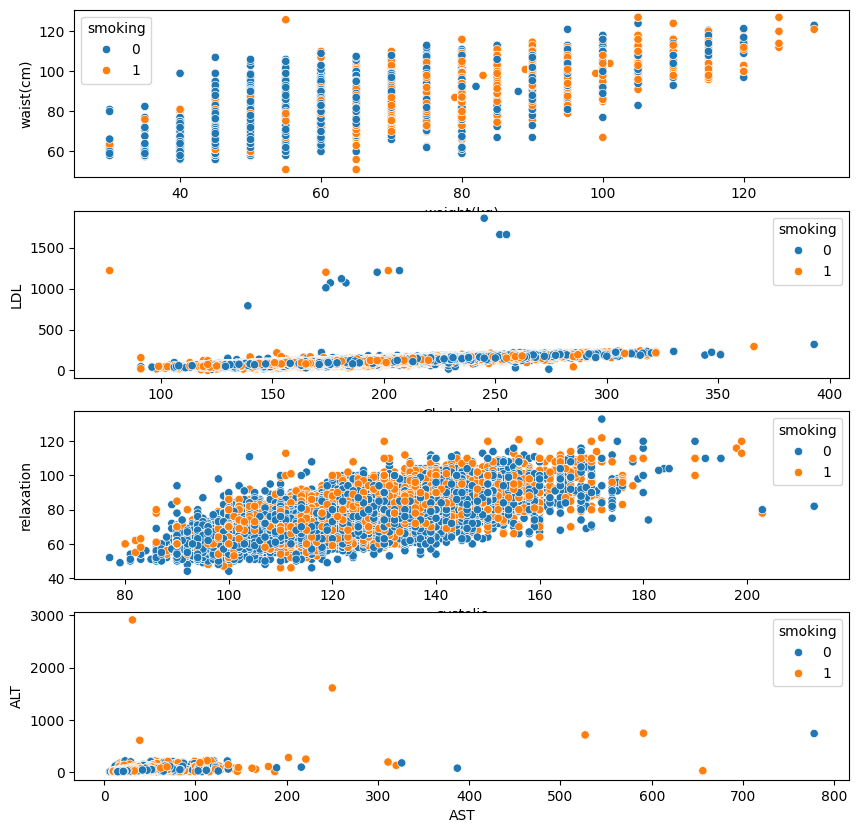

In [30]:
# High correlation scatterplot
figure, axes = plt.subplots(4, 1, figsize=(10, 10))
sns.scatterplot(
    ax=axes[0],
    data=train_data,
    x='weight(kg)',
    y='waist(cm)',
    hue=train_data['smoking'],
)

sns.scatterplot(
    ax=axes[1],
    data=train_data,
    x='Cholesterol',
    y='LDL',
    hue=train_data['smoking'],
)

sns.scatterplot(
    ax=axes[2],
    data=train_data,
    x='systolic',
    y='relaxation',
    hue=train_data['smoking'],
)

sns.scatterplot(
    ax=axes[3],
    data=train_data,
    x='AST',
    y='ALT',
    hue=train_data['smoking'],
)

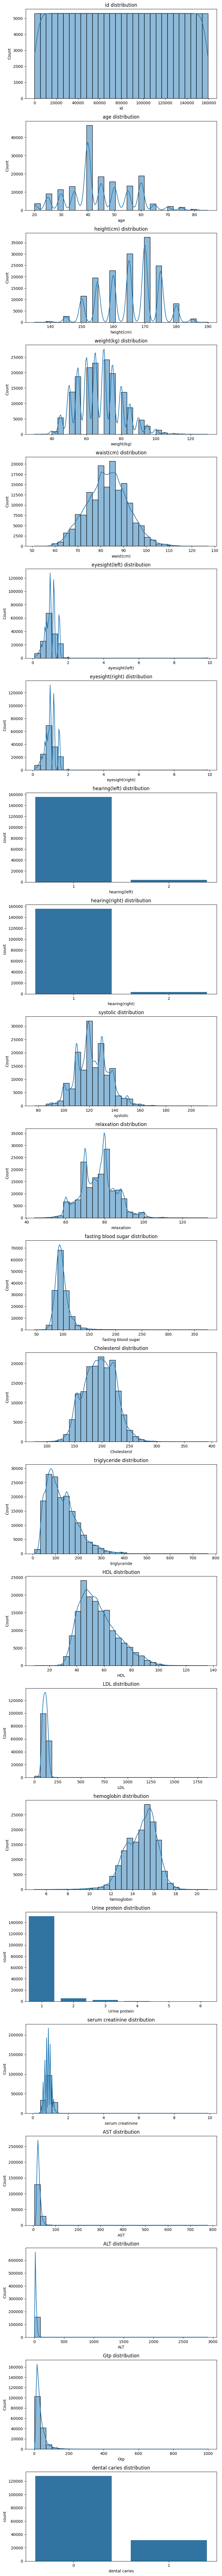

In [31]:
# Variable dataset distributions

cols_to_plot = train_data.columns.drop(['smoking'])

n_rows = len(cols_to_plot)

plt.figure(figsize=(15, 4 * n_rows))

for i, col_name in enumerate(cols_to_plot):
    plt.subplot(n_rows, 2, 2 * i + 1)
    if train_data[col_name].nunique() <= 10:
        sns.countplot(x=col_name, data=train_data)
    else:
        sns.histplot(train_data[col_name], kde=True, bins=30)
    
    plt.title(f'{col_name} distribution')
    plt.tight_layout()

plt.show()

In [32]:
# Unique values in smoking column, understand distribution
uniq = train_data['smoking'].value_counts()
uniq

smoking
0    89603
1    69653
Name: count, dtype: int64

### Data Preprocessing

In [33]:
# Duplicate row removal

train_data = train_data.drop_duplicates()
if train_data.duplicated().sum() == 0:
    print('No duplicates in train data')
else:
    print('Duplicates in train data')

test_data = test_data.drop_duplicates()
if test_data.duplicated().sum() == 0:
    print('No duplicates in test data')
else:
    print('Duplicates in test data')

No duplicates in train data
No duplicates in test data


In [34]:
# Additional features

def feature_engg(df):
    df['BMI'] = df['weight(kg)'] / (df['height(cm)'] / 100 ** 2)
    df['height_waist_ratio'] = df['height(cm)'] / df['waist(cm)']
    df['age_weight_ratio'] = df['age'] / df['weight(kg)']

    df['hdl_ldl_ratio'] = df['HDL'] / df['LDL']
    df['hdl_chol_ratio'] = df['HDL'] / df['Cholesterol']
    df['hdl_tri_ratio'] = df['HDL'] / df['triglyceride']

    df['ast_alt_ratio'] = df['AST'] / df['ALT']

    return df

# Create for training data
train_data = feature_engg(train_data)
# Create for test data
test_data = feature_engg(test_data)

In [35]:
# Feature-target split
X = train_data.drop(['smoking'], axis=1)
y = train_data['smoking']

In [36]:
# Feature importance testing
def feature_importances(df):
    X = df.drop(['smoking'], axis=1)
    y = df['smoking']

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

    # Train a random forest classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Classification report
    print(classification_report(y_test, y_pred))

    # Feature importance
    importances = pd.DataFrame({'Features': X_train.columns, 'Importance': model.feature_importances_})
    importances = importances.sort_values(by='Importance', ascending=False)
    
    # Plot importances
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Features', y='Importance', data=importances)
    plt.xticks(rotation=90)

    plt.show()

              precision    recall  f1-score   support

           0       0.82      0.75      0.78     22269
           1       0.71      0.80      0.75     17545

    accuracy                           0.77     39814
   macro avg       0.77      0.77      0.77     39814
weighted avg       0.78      0.77      0.77     39814



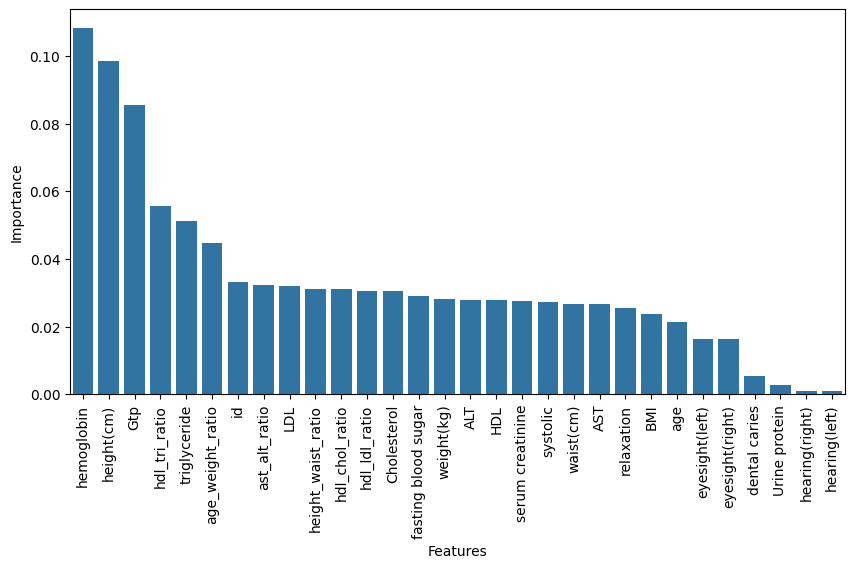

In [37]:
# Feature importance for train data
feature_importances(train_data)

In [38]:
# Notably, Urine protein and hearing are functionally useless features, so we drop them.

# Drop useless features
train_data = train_data.drop(['Urine protein', 'hearing(right)', 'hearing(left)'], axis=1)
test_data = test_data.drop(['Urine protein', 'hearing(right)', 'hearing(left)'], axis=1)

In [39]:
train_data.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,...,Gtp,dental caries,smoking,BMI,height_waist_ratio,age_weight_ratio,hdl_ldl_ratio,hdl_chol_ratio,hdl_tri_ratio,ast_alt_ratio
0,0,55,165,60,81.0,0.5,0.6,135,87,94,...,27,0,1,3636.363636,2.037037,0.916667,0.533333,0.232558,0.133333,0.880000
1,1,70,165,65,89.0,0.6,0.7,146,83,147,...,37,1,0,3939.393939,1.853933,1.076923,0.452381,0.293814,1.036364,1.173913
2,2,20,170,75,81.0,0.4,0.5,118,75,79,...,53,0,1,4411.764706,2.098765,0.266667,0.483871,0.252809,0.228426,0.870968
3,3,35,180,95,105.0,1.5,1.2,131,88,91,...,30,1,0,5277.777778,1.714286,0.368421,0.372549,0.211111,0.187192,0.740741
4,4,30,165,60,80.5,1.5,1.0,121,76,91,...,17,0,1,3636.363636,2.049689,0.500000,0.473118,0.283871,0.505747,1.461538


In [40]:
test_data.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,...,ALT,Gtp,dental caries,BMI,height_waist_ratio,age_weight_ratio,hdl_ldl_ratio,hdl_chol_ratio,hdl_tri_ratio,ast_alt_ratio
0,159256,40,165,70,84.0,1.2,1.2,130,89,107,...,25,32,0,4242.424242,1.964286,0.571429,0.426087,0.245000,0.263441,0.760000
1,159257,80,160,60,93.0,1.0,1.0,144,72,93,...,12,24,0,3750.000000,1.720430,1.333333,0.336538,0.203488,0.221519,1.666667
2,159258,60,170,70,86.5,0.6,0.7,117,75,92,...,60,36,0,4117.647059,1.965318,0.857143,0.443182,0.242236,0.225434,0.633333
3,159259,40,160,50,67.0,0.3,0.4,116,62,91,...,18,10,1,3125.000000,2.388060,0.800000,0.585938,0.352113,1.595745,1.388889
4,159260,40,170,75,89.4,1.0,0.9,132,94,79,...,39,27,1,4411.764706,1.901566,0.533333,0.317073,0.229412,0.390000,0.769231


### Model Building

In [41]:
# Train test split
X = train_data.drop(['smoking'], axis=1)
y = train_data['smoking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((143330, 27), (15926, 27), (143330,), (15926,))

In [42]:
# Using deep learning to predict smoking status
# Library used: Tensorflow
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import roc_auc_score

# Number of features
n_features = X_train.shape[1]
n_features

27

In [43]:
# Define model
model = Sequential()
# first layer
model.add(Dense(512, activation='relu', input_shape=(n_features,)))
model.add(Dense(320, activation='relu'))
model.add(Dense(256, activation='selu'))
model.add(BatchNormalization())
model.add(Dropout(.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.3))
model.add(Dense(32, activation='mish'))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=0.01,
)

# Legacy Adam used due to M2 Mac usage

model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.AUC()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               14336     
                                                                 
 dense_10 (Dense)            (None, 320)               164160    
                                                                 
 dense_11 (Dense)            (None, 256)               82176     
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                      

In [44]:
# Model training
history = model.fit(
    X, y,
    epochs=120,
    batch_size=512,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True, start_from_epoch=40, mode='auto')],
    validation_data=(X_test, y_test),
    verbose=2
)

Epoch 1/120
312/312 - 5s - loss: 0.2468 - auc_1: 0.4973 - val_loss: 0.2467 - val_auc_1: 0.4968 - 5s/epoch - 15ms/step
Epoch 2/120
312/312 - 4s - loss: 0.2461 - auc_1: 0.5037 - val_loss: 0.2468 - val_auc_1: 0.5016 - 4s/epoch - 12ms/step
Epoch 3/120
312/312 - 4s - loss: 0.2461 - auc_1: 0.4978 - val_loss: 0.2468 - val_auc_1: 0.5000 - 4s/epoch - 13ms/step
Epoch 4/120
312/312 - 4s - loss: 0.2461 - auc_1: 0.5003 - val_loss: 0.2467 - val_auc_1: 0.5021 - 4s/epoch - 12ms/step
Epoch 5/120
312/312 - 4s - loss: 0.2457 - auc_1: 0.5161 - val_loss: 0.2481 - val_auc_1: 0.5000 - 4s/epoch - 12ms/step
Epoch 6/120
312/312 - 4s - loss: 0.2042 - auc_1: 0.7391 - val_loss: 0.2896 - val_auc_1: 0.6764 - 4s/epoch - 12ms/step
Epoch 7/120
312/312 - 4s - loss: 0.1781 - auc_1: 0.8020 - val_loss: 0.1855 - val_auc_1: 0.8051 - 4s/epoch - 12ms/step
Epoch 8/120
312/312 - 4s - loss: 0.1736 - auc_1: 0.8108 - val_loss: 0.2110 - val_auc_1: 0.7865 - 4s/epoch - 12ms/step
Epoch 9/120
312/312 - 4s - loss: 0.1713 - auc_1: 0.8150 

### Model Evaluation

In [45]:
y_pred = model.predict(test_data)
y_pred

3318/3318 [==============================] - 3s 992us/step


array([[0.49761364],
       [0.10918833],
       [0.64920974],
       ...,
       [0.46467483],
       [0.06774089],
       [0.0101999 ]], dtype=float32)

### Results and Conclusions

In [46]:
# Load submission file
submission = pd.read_csv(sample_submission_path)
submission.head()

,id,smoking
0,159256,0.5
1,159257,0.5
2,159258,0.5
3,159259,0.5
4,159260,0.5


In [47]:
submission['smoking'] = y_pred
submission.head()

,id,smoking
0,159256,0.497614
1,159257,0.109188
2,159258,0.649210
3,159259,0.038856
4,159260,0.583453


In [48]:
submission.to_csv(output_path, index=False)
submission.head()

,id,smoking
0,159256,0.497614
1,159257,0.109188
2,159258,0.649210
3,159259,0.038856
4,159260,0.583453
